 # **Customer Behaviour Segmentation Analysis**

#  Importing Libraries

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# Data Understanding

In [2]:
# Load dataset using panda read_csv to check first five rows
df = pd.read_csv('Dataset_ecommerce.csv')
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


# Dataset Description:

1. InvoiceNo: Code representing each unique transaction.
2. StockCode:	Code uniquely assigned to each distinct product.
3. Description:	Description of each product.
4. Quantity:	The number of units of a product in a transaction.
5. InvoiceDate:	The date and time of the transaction.
6. UnitPrice:	The unit price of the product in sterling.
7. CustomerID:	Identifier uniquely assigned to each customer.
8. Country:	The country of the customer.

In [3]:
#check data shape
df.shape

(541909, 8)

In [4]:
#check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   InvoiceDate  541909 non-null  object 
 2   CustomerID   406829 non-null  float64
 3   StockCode    541909 non-null  object 
 4   Description  541909 non-null  object 
 5   Quantity     541909 non-null  int64  
 6   UnitPrice    541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Check duplicate values
df.duplicated().sum()

# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

The dataset contains 0 duplicate rows that need to be removed.


In [6]:
# Checking for missing values in dataset
df.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

In [7]:
# check data statistics
df.describe(include='all').round(2)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
count,541909,541909,406829.00,541909,541909,541909.00,541909.00,541909
unique,25900,23260,NaN,9000,10,NaN,NaN,28
top,573585,2011-10-31 14:41:00,NaN,SC2014,Sports Equipment,NaN,NaN,Cote d'Ivoire
freq,1114,1114,NaN,96,54765,NaN,NaN,19651
mean,NaN,NaN,15287.69,NaN,NaN,50.53,50.48,NaN
std,NaN,NaN,1713.60,NaN,NaN,28.85,28.56,NaN
min,NaN,NaN,12346.00,NaN,NaN,1.00,1.00,NaN
25%,NaN,NaN,13953.00,NaN,NaN,26.00,25.75,NaN
50%,NaN,NaN,15152.00,NaN,NaN,51.00,50.43,NaN
75%,NaN,NaN,16791.00,NaN,NaN,76.00,75.18,NaN


# Comments:

1.   The data has 541,909 rows and  8 features.
2.   The missing values is from "CustomerID" only having missing values of 	135,080. The rows will be removed from the data.
3.   No duplicated values observed in the data.
4.   Unique Values: The unique vales are made of 28 countries , 22,190 invoices, 9,000 stock code.
5.   The data types consist of 5 objects, 2 floats , and 1 interger.
6.   The common words from 'Description' and 'Country' are 'Sports equipments' and 'Cote d'Ivouire'.


# Data Preprocessing

In [8]:
# Drop rows with missing values
df.dropna(inplace=True)

# Verifying the removal of missing values
print("No of missing values:", df.isnull().sum().sum())

print('Cleaned Dataset:', df.shape)

No of missing values: 0
Cleaned Dataset: (406829, 8)


# Exploratory Data Analysis (EDA)

# Monthly Sales Trend

Monthly Sales Trend:
        Month  Total Sales
0  2010-12-01      1350834
1  2011-01-01      1105886
2  2011-02-01      1033468
3  2011-03-01      1406617
4  2011-04-01      1175052
5  2011-05-01      1459981
6  2011-06-01      1402857
7  2011-07-01      1388119
8  2011-08-01      1387695
9  2011-09-01      2061181
10 2011-10-01      2559609
11 2011-11-01      3313177
12 2011-12-01       891630


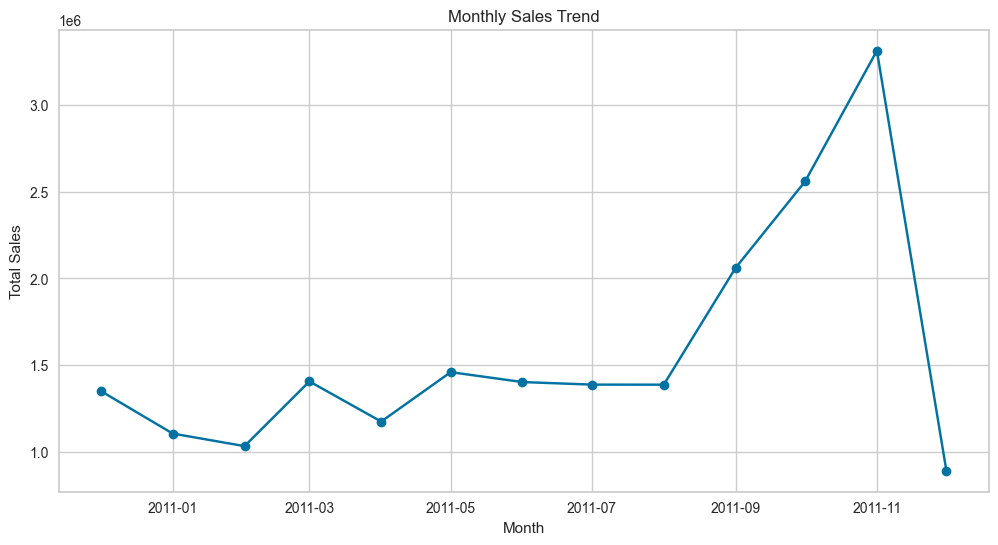

In [9]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Group by InvoiceDate and sum the sales
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['Quantity'].sum()

# Convert the Series to a DataFrame
monthly_sales_df = monthly_sales.reset_index()
monthly_sales_df.columns = ['Month', 'Total Sales']
monthly_sales_df['Month'] = monthly_sales_df['Month'].dt.to_timestamp()

# Display the table
print("Monthly Sales Trend:")
print(monthly_sales_df)

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_df['Month'], monthly_sales_df['Total Sales'], marker='o')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend')
plt.grid(True)
plt.show()


# Monthly Sales Trend Analysis:

* General Trend:

The sales trend exhibits fluctuations throughout the year, with some months showing significant peaks.
A steady increase is observed from September to November 2011, followed by a sharp drop in December 2011.

* High Sales Periods:

September to November 2011 recorded the highest sales likely due to holiday shopping or promotional activities indicating a strong build-up to the holiday season.

* Low Sales Periods:

December to February 2011 had the lowest sales possibly due to reduced activity after the holiday peak.

# Cutomer Retention Cohort Analysis

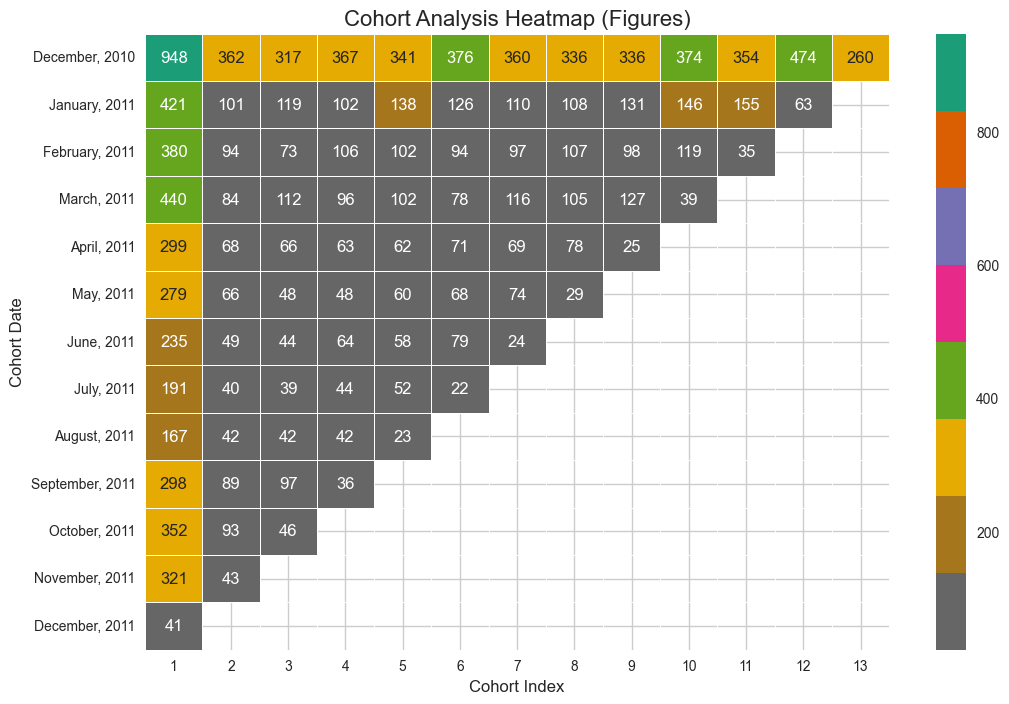

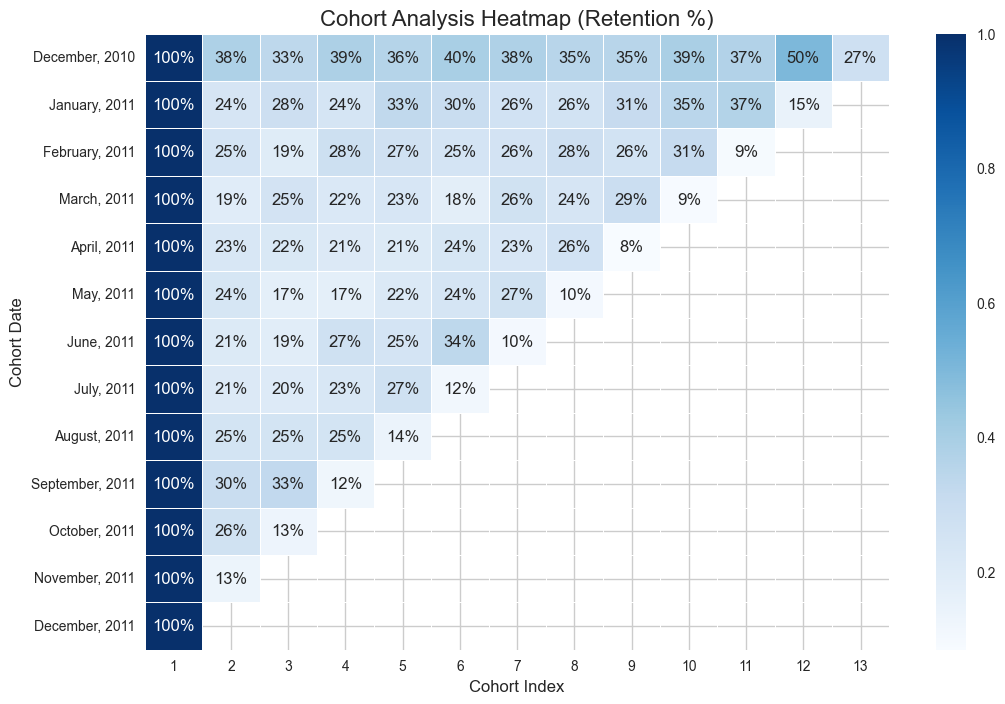

In [10]:
# Convert InvoiceDate to first day of the month
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).apply(lambda x: pd.Timestamp(x.year, x.month, 1))

# Create cohort_date (first purchase date per customer)
df['cohort_date'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')

# Calculate cohort index
df['cohort_index'] = (df['InvoiceDate'].dt.year - df['cohort_date'].dt.year) * 12 + (df['InvoiceDate'].dt.month - df['cohort_date'].dt.month) + 1

# Group by cohort_date and cohort_index to count unique customers
cohort_table = df.groupby(['cohort_date', 'cohort_index'])['CustomerID'].nunique().unstack()

# Convert index to readable format
cohort_table.index = cohort_table.index.strftime('%B, %Y')

# Plot Cohort Analysis Heatmap (Figures)
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_table, annot=True, fmt='g', cmap='Dark2_r', linewidths=0.5)
plt.title('Cohort Analysis Heatmap (Figures)', fontsize=16)
plt.xlabel('Cohort Index', fontsize=12)
plt.ylabel('Cohort Date', fontsize=12)
plt.yticks(rotation=0)
plt.show()

# Calculate percentage retention
cohort_retention = cohort_table.divide(cohort_table.iloc[:, 0], axis=0)

# Plot Cohort Analysis Heatmap (Percentage Retention)
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_retention, annot=True, fmt='.0%', cmap='Blues', linewidths=0.5)
plt.title('Cohort Analysis Heatmap (Retention %)', fontsize=16)
plt.xlabel('Cohort Index', fontsize=12)
plt.ylabel('Cohort Date', fontsize=12)
plt.yticks(rotation=0)
plt.show()


# Comment:

   Customer Percentage Retention Analysis:
   Analyzing the heatmap, the average benchmark retention rate ranges between 30% and 40%. Notably, only December 2010 managed to sustain this benchmark, even achieving a 50% retention rate by the 12th month. This is followed by January 2011, which also performed relatively well. In contrast, other months have maintained lower retention rates, ranging between 20% and 29%.

# Feature Engineering

 Here, the new features creates is based on RFM Analysis:
 1. Recency (R)
Recency measures how recently a customer has made a purchase, providing insights into their engagement with the business.
2. Frequency (F): measures total number of unique transactions made by a customer
3. Moetary: measures the total amount spent by each
customer.

In [ ]:
# ======= FEATURE ENGINEERING (RFM Analysis) =========

# Get the most recent date in the dataset
max_date = df["InvoiceDate"].max()

# Compute RFM Metrics
rfm_df = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (max_date - x.max()).days),  # Days since last purchase
    Frequency=("InvoiceNo", "count"),  # Number of purchases
    Monetary=("UnitPrice", lambda x: (x * df.loc[x.index, "Quantity"]).sum())  # Total spent
).reset_index()

# Compute Average Monetary Value
rfm_df["Av_Monetary_Value"] = rfm_df["Monetary"] / rfm_df["Frequency"]

# Compute the total quantity of products bought by each customer
product_totals = df.groupby("CustomerID")["Quantity"].sum().reset_index()
product_totals.rename(columns={"Quantity": "Total_Products"}, inplace=True)

# Merge Total Products into RFM DataFrame
rfm_df = rfm_df.merge(product_totals, on="CustomerID", how="left")


rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,Av_Monetary_Value,Total_Products
0,12346.0,334,2,5342.40,2671.200000,119
1,12347.0,0,182,431501.00,2370.884615,8511
2,12348.0,91,31,82378.47,2657.370000,1539
3,12349.0,30,73,176075.12,2411.987945,3434
4,12350.0,303,17,48173.37,2833.727647,917


In [ ]:
#check new data shape
rfm_df.shape

(4372, 6)

In [13]:
# Check duplicate values
rfm_df.duplicated().sum()

# Displaying the number of duplicate rows
print(f"The dataset contains {rfm_df.duplicated().sum()} duplicate rows that need to be removed.")

The dataset contains 0 duplicate rows that need to be removed.


# Features Correlation Analysis

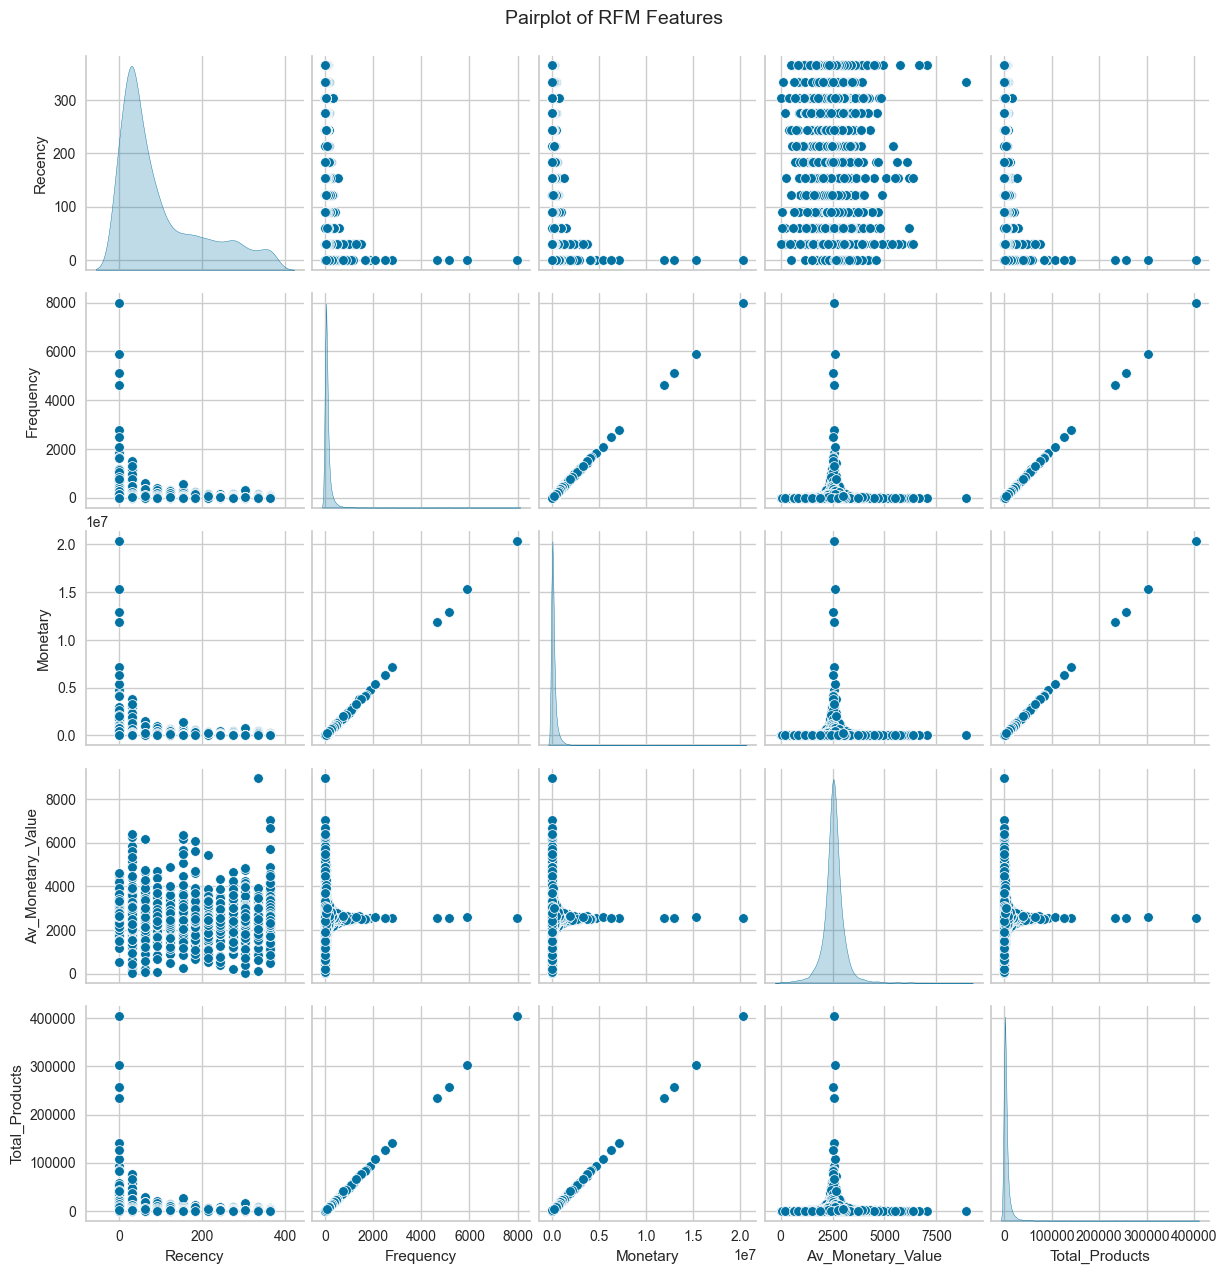

In [14]:
#  Pairplot for Feature Relationships
sns.pairplot(rfm_df[['Recency', 'Frequency', 'Monetary', 'Av_Monetary_Value',
       'Total_Products']], diag_kind='kde')
plt.suptitle("Pairplot of RFM Features", y=1.02, fontsize=14)
plt.show()

# Comment
The pairplot reveals evidence of churn rate.

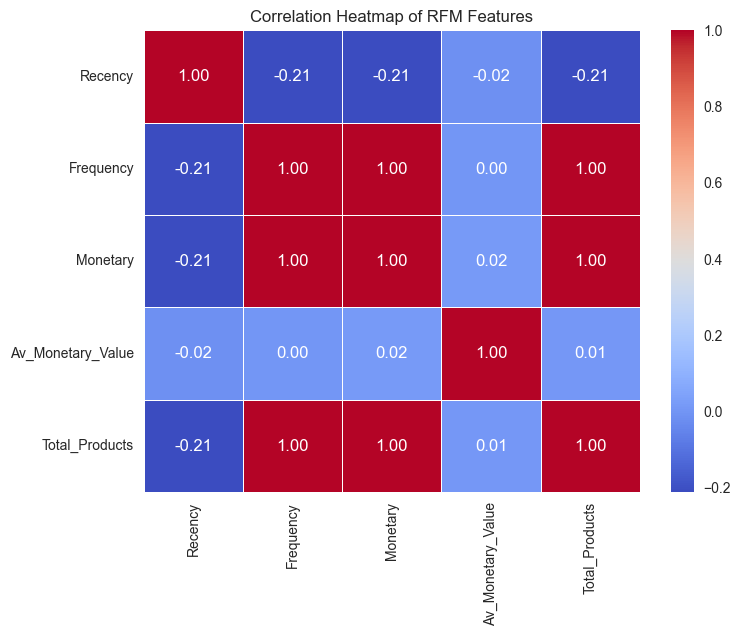

In [15]:
# 2 Heatmap to Show Correlations
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_df[['Recency', 'Frequency', 'Monetary', 'Av_Monetary_Value',
       'Total_Products']].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of RFM Features")
plt.show()

# Comment
The heatmap shows that recency is correllated with total products, monetary, frequency, although by a minimal margin.

In [16]:
## ======= FEATURE SCALING =========

rfm_df_copy = rfm_df.copy()

# Feature columns
X_pca = ["Recency", "Frequency", "Monetary" , "Av_Monetary_Value",
       "Total_Products" ]

# Best Method: StandardScaler (good for clustering when data varies in scale)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_df_copy[X_pca])


 PCA Component Loadings:


,Recency,Frequency,Monetary,Av_Monetary_Value,Total_Products
PC1,-0.174893,0.568402,0.568425,0.008793,0.568460
PC2,-0.173814,-0.029774,-0.015381,0.983927,-0.023544
PC3,0.969124,0.096957,0.099941,0.178052,0.098526


C:\Users\Kenny Ogundana\AppData\Local\Temp\ipykernel_41136\2368763658.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"PC{i+1}" for i in range(3)], y=explained_variance, palette="Blues_r")


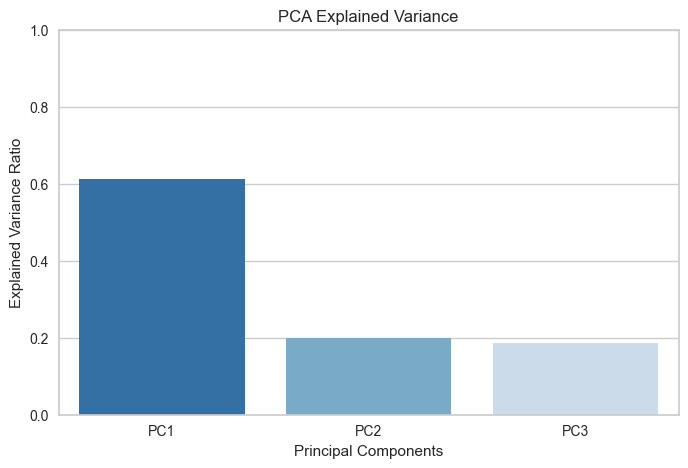

In [ ]:
# ======= FEATURE SELECTION =========
#  PCA (Check for dimensionality reduction)

# Perform PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for PCA loadings
pca_df = pd.DataFrame(
    pca.components_,
    columns=X_pca,
    index=[f"PC{i+1}" for i in range(3)]
)

# Function to highlight important features (highest absolute values per PC)
def highlight_important_features(s):
    is_max = s.abs() == s.abs().max()  # Check the highest absolute value in each row
    return ['background-color: lightgreen' if v else '' for v in is_max]

#  Table Format - Display PCA Loadings with Highlighted Features
styled_pca_df = pca_df.style.apply(highlight_important_features, axis=1)
print("\n PCA Component Loadings:")
display(styled_pca_df)

#  Scree Plot - Explained Variance
plt.figure(figsize=(8, 5))
sns.barplot(x=[f"PC{i+1}" for i in range(3)], y=explained_variance, palette="Blues_r")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance")
plt.ylim(0, 1)
plt.show()


# Comment:

The plot and cumulative explained variance show how much variance each principal component captures:

  * First component: Explains ~61% of the variance.
  * First two components: Explain ~81% combined.

For customer segmentation, retaining the first 2 components balances can explained the variance suficiently.

# Finding Optimal Clusters

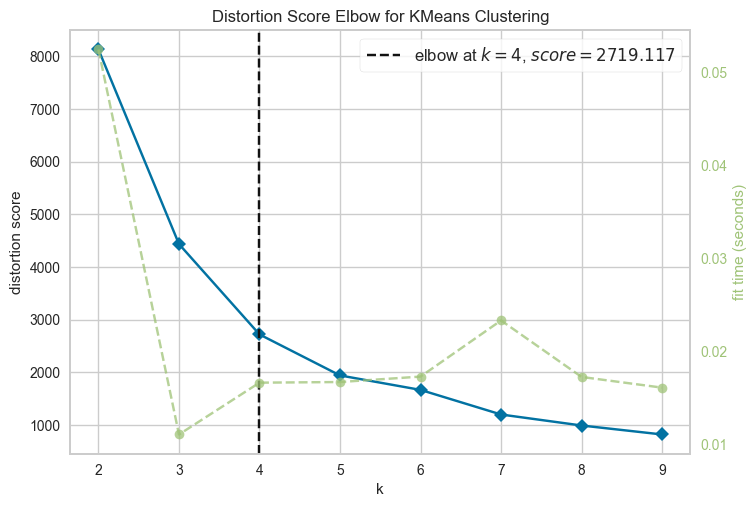

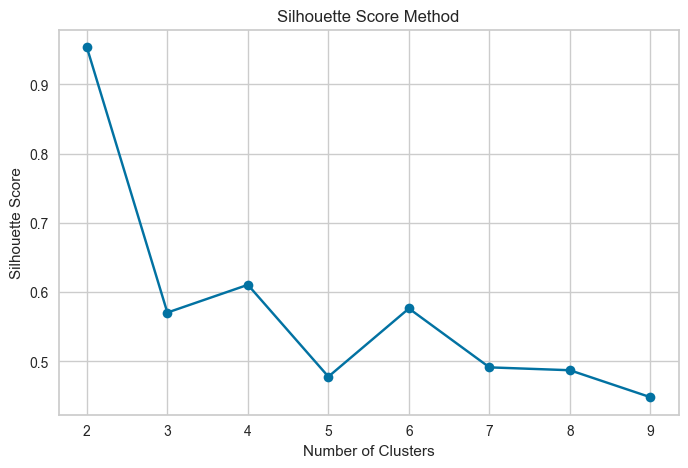

   Number of Clusters (K)  Elbow Score  Silhouette Score
0                       2  8131.140908          0.953726
1                       3  4435.543814          0.570543
2                       4  2719.117400          0.610618
3                       5  1940.404594          0.477998
4                       6  1665.726863          0.576463
5                       7  1198.328646          0.491414
6                       8   989.553706          0.487271
7                       9   819.186526          0.448294


In [24]:
# ======= FIND OPTIMAL CLUSTERS (K) =========

# Feature columns
#feature_columns = ["Recency", "Frequency", "Monetary" ]
X_pca = ["Recency", "Frequency", "Monetary" ]

# Best Method: StandardScaler (good for clustering when data varies in scale)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_df_copy[X_pca])



# 1. Elbow Method
elbow_model = KElbowVisualizer(KMeans(), k=(2, 10))
elbow_model.fit(scaled_features)
elbow_model.show()

# 2️. Silhouette Method
silhouette_scores = []
for k in range(2, 10):
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, marker="o")
plt.title("Silhouette Score Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Creating a DataFrame to store both Elbow and Silhouette scores
results_df = pd.DataFrame({
    "Number of Clusters (K)": range(2, 10),
    "Elbow Score": elbow_model.k_scores_,
    "Silhouette Score": silhouette_scores
})

# Display the DataFrame
print(results_df)

# Comment:

Both the Elbow Method and the Silhouette Score suggest that **optimal Clusters: K = 4**.
It represents a balance between compactness (low Elbow Score) and cluster quality (high Silhouette Score).

# Best Model Hyperparameter Tunning



 In this section, four models—KMeans, Agglomerative Clustering, Hierarchical Clustering, and DBSCAN were trained with 4 cluster sizes to visualize the optimal number of clusters for customer segmentation. The results for each cluster size were then evaluated. 

Optimal: 4


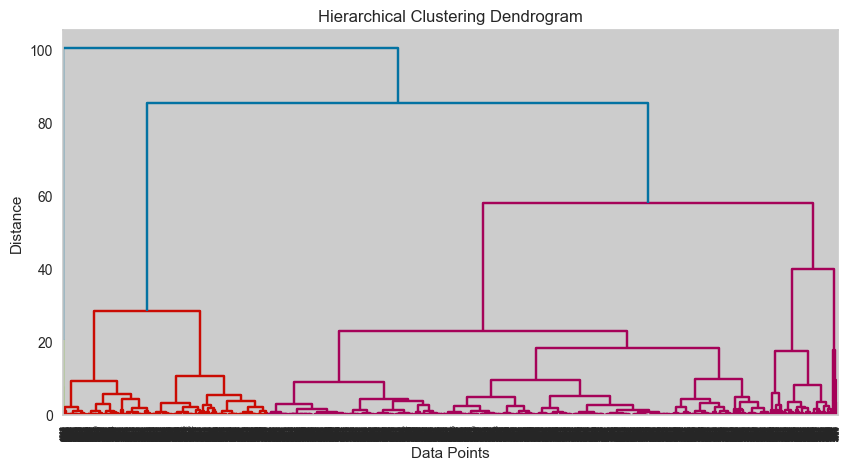

,Model,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
0,KMeans,0.606087,5605.263293,0.510074
1,Agglomerative,0.596841,5484.691494,0.532780
2,Hierarchical,0.596841,5484.691494,0.532780
3,DBSCAN,0.759562,1119.417464,0.932105


In [ ]:
# ======= APPLY CLUSTERING MODELS =========
rfm_df_copy = rfm_df.copy()

optimal_k = elbow_model.elbow_value_
print("Optimal:", optimal_k)

# 1️⃣ KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_df_copy["KMeans"] = kmeans.fit_predict(scaled_features)

# 2️⃣ Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k)
rfm_df_copy["Agglomerative"] = agglo.fit_predict(scaled_features)

# 3️⃣ DBSCAN (Automatic parameter tuning needed for best results)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
rfm_df_copy["DBSCAN"] = dbscan.fit_predict(scaled_features)

# 4️⃣ Hierarchical Clustering - Dendrogram
linkage_matrix = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Assign cluster labels from the dendrogram
rfm_df_copy["Hierarchical"] = fcluster(linkage_matrix, optimal_k, criterion='maxclust')

# ======= CLUSTERING EVALUATION =========
evaluation_metrics = []

for model_name in ["KMeans", "Agglomerative", "Hierarchical"]:
    silhouette = silhouette_score(scaled_features, rfm_df_copy[model_name])
    calinski = calinski_harabasz_score(scaled_features, rfm_df_copy[model_name])
    davies = davies_bouldin_score(scaled_features, rfm_df_copy[model_name])

    evaluation_metrics.append({
        "Model": model_name,
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Score": calinski,
        "Davies-Bouldin Score": davies
    })

# DBSCAN does not support Silhouette & Calinski-Harabasz scores if all points are noise (-1)
if len(set(rfm_df_copy["DBSCAN"])) > 1:
    silhouette = silhouette_score(scaled_features, rfm_df_copy["DBSCAN"])
    calinski = calinski_harabasz_score(scaled_features, rfm_df_copy["DBSCAN"])
    davies = davies_bouldin_score(scaled_features, rfm_df_copy["DBSCAN"])

    evaluation_metrics.append({
        "Model": "DBSCAN",
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Score": calinski,
        "Davies-Bouldin Score": davies
    })

# Convert to DataFrame
clustering_evaluation_df = pd.DataFrame(evaluation_metrics)

# Display the evaluation results
clustering_evaluation_df

# Comment:
 **KMeans**  is the best overall model because:

- It has the highest Calinski-Harabasz Score, meaning its clusters are compact and well-separated.
- It has the lowest Davies-Bouldin Score, meaning its clusters are well-distinguished.
- Its Silhouette Score (0.6061) is good, although DBSCAN is higher, but DBSCAN struggles with compactness.

# Best Model Clustering Application - KMeans

In [ ]:
# CustomerID is set as the index
if 'CustomerID' in rfm_df.columns:
    rfm_df.set_index('CustomerID', inplace=True)

# Select the features to be used for clustering
features = rfm_df[["Recency", "Frequency", "Monetary", "Av_Monetary_Value", "Total_Products"]]

# Data Preprocessing
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(features)

# Convert the standardized data back to a DataFrame
customer_data_scaled = pd.DataFrame(
    customer_data_scaled,
    columns=features.columns,
    index=rfm_df.index
)

# If 'cluster' column exists, drop it 
rfm_df = rfm_df.drop(columns=['cluster'], errors='ignore')

# print or inspect the scaled data
print(customer_data_scaled.head())


             Recency  Frequency  Monetary  Av_Monetary_Value  Total_Products
CustomerID                                                                  
12346.0     2.341636  -0.391720 -0.390228           0.226169       -0.389483
12347.0    -0.964201   0.382657  0.326737          -0.321723        0.324455
12348.0    -0.063509  -0.266959 -0.260623           0.200938       -0.268679
12349.0    -0.667269  -0.086271 -0.102989          -0.246734       -0.107464
12350.0     2.034807  -0.327188 -0.318169           0.522682       -0.321594


C:\Users\Kenny Ogundana\AppData\Local\Temp\ipykernel_41136\563818247.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=palette)


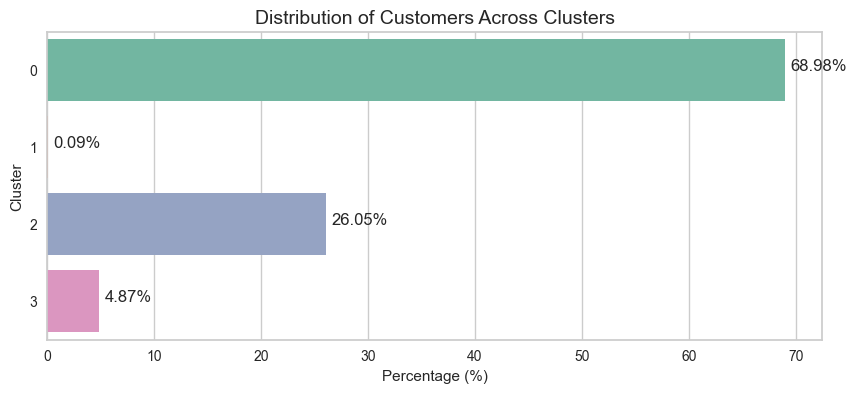

-----------------Distribution of Customers Across Clusters-------------------
          Recency  Frequency   Monetary  Av_Monetary_Value  Total_Products
cluster                                                                   
0       -0.506327  -0.068522  -0.067947           0.006352       -0.068092
1       -0.964201  25.042252  25.099297           0.028102       25.073298
2        1.494047  -0.282959  -0.282743          -0.016811       -0.282768
3       -0.801795   2.013069   2.002703          -0.000579        2.005378


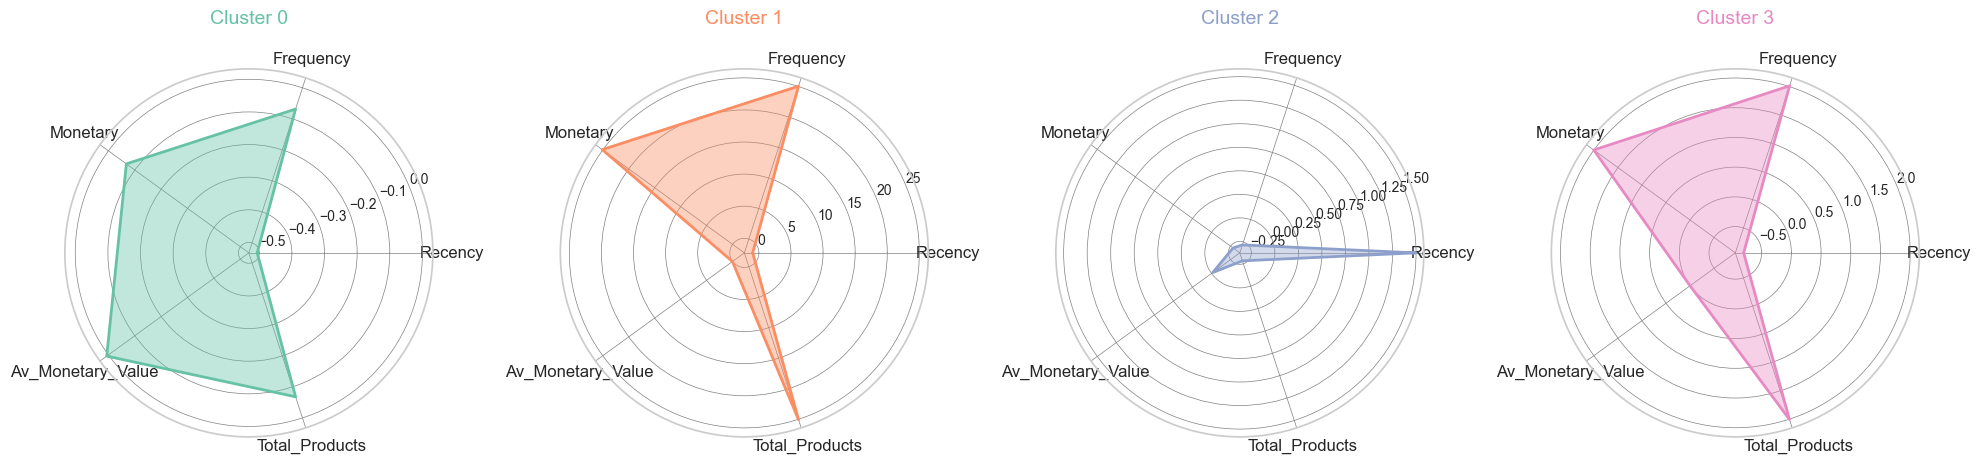

In [29]:
# Fit KMeans model
optimal_k = optimal_k  
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans_labels = kmeans.fit_predict(customer_data_scaled)

# Assign cluster labels to the original dataset
rfm_df['cluster'] = kmeans_labels

# Analyze Cluster Distribution
def plot_cluster_distribution(data, palette):
    cluster_percentage = (data['cluster'].value_counts(normalize=True) * 100).reset_index()
    cluster_percentage.columns = ['Cluster', 'Percentage']

    # Sort clusters in ascending order
    cluster_percentage.sort_values(by='Cluster', ascending=True, inplace=True)

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=palette)

    # Adding percentages on the bars
    for index, value in enumerate(cluster_percentage['Percentage']):
        plt.text(value + 0.5, index, f'{value:.2f}%')

    plt.title('Distribution of Customers Across Clusters', fontsize=14)
    plt.xlabel('Percentage (%)')
    plt.show()

# Plot cluster distribution
colors = sns.color_palette("Set2", optimal_k)
plot_cluster_distribution(rfm_df, colors)


print("-----------------Distribution of Customers Across Clusters-------------------")
# Compute cluster centroids for KMeans
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=customer_data_scaled.columns)
# Compute cluster centroids
cluster_centroids = customer_data_scaled.groupby(rfm_df['cluster']).mean()
print(cluster_centroids)

# Radar Chart Setup
labels = cluster_centroids.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart loop

# Function to create radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=14, color=color, y=1.1)


# Create radar charts for each cluster
fig, axes = plt.subplots(1, optimal_k, figsize=(20, 6), subplot_kw=dict(polar=True))

for i, ax in enumerate(axes):
    data = cluster_centroids.iloc[i].tolist() + cluster_centroids.iloc[i].tolist()[:1]
    create_radar_chart(ax, angles, data, sns.color_palette("Set2", optimal_k)[i], cluster=i)

# Add labels to the radar chart
for ax in axes:
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()


# Customers Clustering Analysis:

1. **Cluster 0(Low Recency, Moderate Frequency & Monetary Value): Average Customers** 

   Customers in this cluster recently made purchases and they forms the majority (68.98%), but their buying frequency and monetary contributions are average or slightly below average.

   Recommendation Strategies:

      - Loyalty Programs: Introduce rewards for consistent purchases to increase frequency.
      - Personalized Offers: Use targeted discounts to incentivize slightly increased spending.
      - Customer Engagement: Send thank-you messages or product recommendations to maintain engagement.


2. **Cluster 1(High Frequency & High Monetary Value): Top Spenders/High-Value Loyal Customers** 

   This is the most valuable customer segment(makes up only 0.09% but critical for revenue,) with high purchase frequency, high spending, and recent transactions.

   Recommendation Strategies:

      - VIP Programs: Offer exclusive benefits, early access to products, or premium support.
      - Cross-Selling and Upselling: Introduce high-end products or bundles since they are willing to spend.
      - Retention Focus: Send personalized thank-you notes and loyalty points to reinforce their value to the business.

3. **Cluster 2(High Recency, Low Frequency & Low Monetary Value)   :At-Risk (Churned) Customers**  
   Customers in this cluster are at risk of churn (represents 26.05%) as they haven’t purchased recently, and their spending is below average.

   Recommendation Strategies:

      - Win-Back Campaigns: Offer discounts or incentives to re-engage them.
      - Survey and Feedback: Understand reasons for disengagement and improve accordingly.
      - Reminder Emails: Send gentle nudges with product updates or special deals.
      - Reactivation Offers: Provide time-sensitive discounts to encourage purchase.

4. **Cluster 3(Moderate Recency, Moderate Frequency & Monetary Value): Potential Loyalists**  

      These customers(making up of 4.87%) are moderately active and have slightly higher-than-average spending, indicating potential for loyalty.

      Recommendation Strategies:

      - Retention Campaigns: Offer discounts on frequently purchased products to maintain engagement.
      - Personalization: Tailor offers based on their previous purchase patterns.
      - Build Brand Loyalty: Introduce membership perks or early access to sales.
      - Social Proof: Encourage reviews and referrals as they are moderately engaged.


**General Recommendations:**

1. **Customer Segmentation Marketing:** Use these insights to build targeted marketing strategies for each cluster.

2. **Retention Strategy:** 
      - Invest more in Cluster 1 (top spenders) to maintain loyalty.
      - Focus on Cluster 2 to win back customers before they churn.

3. **Personalized Communication:** Automate segmented email campaigns targeting each cluster with appropriate content.

4. **Product Strategy:**
      - For Cluster 3, highlight new product lines or complementary items to increase frequency.
      - For Cluster 0, showcase popular or related products to boost their spending slightly.

5. **Identify Key Drivers of High Retention:**
      Analyze the factors that led to the high retention rate observed in the Customer Retention Cohort Analysis for December 2010. Determine whether successful elements such as marketing campaigns, product enhancements, or customer engagement initiatives played a role. Replicate these effective strategies across other cohorts to boost retention.

6. **Investigate the Retention Drop in December 2011:**
      Examine why retention rates declined across all cohorts in December 2011. Potential areas of investigation include customer feedback, product quality, customer service issues, or any operational changes during that period. Identifying and addressing these root causes will help improve future retention outcomes.

7. **Set Realistic and Business-Specific Retention Targets:**
      While the typical e-commerce retention rate ranges from 20% to 40%, it's essential to establish goals tailored to your specific business context. Use historical data and industry benchmarks to set achievable targets, aiming for gradual improvements over time.

8. **Monitor and Adapt Continuously:**
      Retention dynamics can shift due to various factors, so it’s important to regularly track retention metrics and customer behavior. Continuously analyze cohort data and make data-driven adjustments to your retention strategies to maintain high customer loyalty.


Now that the company understands its customer segments and their behavior, use this information to craft targeted marketing strategies. Focus on areas with high product sales rather than just high customer acquisition, ensuring a more strategic approach to increasing sales and ROI.
